
# Transaction Analysis

**Conteúdo:**
1. Carregamento e normalização dos dados  
2. Seção 1 — Estatísticas e sazonalidade  
3. Seção 2 — Identificação de padrões e outliers  
4. Seção 3 — Proposta de ferramenta acionável (fluxo de alertas)  
5. Seção 4 — Métrica calculável por sistema (código + JSON)  

In [29]:
import os, io, math, shutil, zipfile, textwrap
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths
BASE = ""
CSV_PATH = f"{BASE}/transactions.csv"

REPO_DIR = os.path.join(BASE, "data_scientist_test_repo")
ANALYSIS_DIR = os.path.join(REPO_DIR, "analysis")
PROPOSAL_DIR = os.path.join(REPO_DIR, "proposal")
CODE_DIR = os.path.join(REPO_DIR, "code")
ASSETS_DIR = os.path.join(REPO_DIR, "assets")

for d in [REPO_DIR, ANALYSIS_DIR, PROPOSAL_DIR, CODE_DIR, ASSETS_DIR]:
    os.makedirs(d, exist_ok=True)

Diretórios prontos: /content/drive/MyDrive/cloudwalk/data_scientist_test_repo


## 1) Carregamento e normalização

In [30]:

# Carregar
df = pd.read_csv(CSV_PATH)

# Normalizar nomes
df.columns = [c.strip().lower() for c in df.columns]

# Tipos
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
if "amount" in df.columns:
    df["amount"] = pd.to_numeric(df["amount"], errors="coerce")

# Manter linhas válidas
df = df.dropna(subset=["date", "amount"]).copy()
df.head()


,id,account_id,description,description_raw,category,currency_code,amount,balance,date,status,type,provider_code,created_at,updated_at,payment_data,credit_card_data,merchant
0,00101b10-8204-4ce3-bea0-68c2f152db4a,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX ENVIADO Joao Vitor Sousa Escudero,PIX ENVIADO Joao Vitor Sousa Escudero,Transferência mesma titularidade,BRL,-1012.58,NaN,2025-08-01 15:01:28.374,POSTED,DEBIT,NaN,2025-08-02 04:16:04.527,2025-08-06 04:21:48.072,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN
1,00219086-4722-439e-b285-7f133acde977,bccb05e6-5f09-4aee-b8e4-719d85c09692,RECARGA TELEFONE CELULAR IB 11 *****0859 TIM...,RECARGA TELEFONE CELULAR IB 11 *****0859 TIM...,Telecomunicação,BRL,-20.00,NaN,2025-07-21 18:18:57.776,POSTED,DEBIT,NaN,2025-07-29 13:47:58.698,2025-07-30 04:30:22.849,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,"{""cnae"":""6110801"",""cnpj"":""02421421000111"",""nam..."
2,0071a75f-dd2b-490d-b06a-1d84963d3b49,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,PIX RECEBIDO JOAO VITOR SOUSA ESCUDERO,Transferência mesma titularidade,BRL,200.00,NaN,2025-04-24 08:09:26.323,POSTED,CREDIT,NaN,2025-07-29 13:47:58.763,2025-07-30 04:30:22.886,"{""payer"":{""name"":null,""branchNumber"":""0001"",""a...",NaN,NaN
3,00b6e801-b9a0-40c6-be2b-e859b7625f4b,bccb05e6-5f09-4aee-b8e4-719d85c09692,PIX ENVIADO Ff Tech E Participacoes L,PIX ENVIADO Ff Tech E Participacoes L,Serviços digitais,BRL,-42.33,NaN,2025-07-18 21:46:05.201,POSTED,DEBIT,NaN,2025-07-29 13:47:58.7,2025-07-30 04:30:22.85,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,"{""cnae"":""6202300"",""cnpj"":""37571055000161"",""nam..."
4,00c8c46d-3d0e-4298-b9d9-fcabc9d9076c,bccb05e6-5f09-4aee-b8e4-719d85c09692,DEBITO VISA ELECTRON BRASIL 25/06 57.326.384...,DEBITO VISA ELECTRON BRASIL 25/06 57.326.384...,Transferência para terceiros - Débito,BRL,-87.00,NaN,2025-06-25 18:21:35.509,POSTED,DEBIT,NaN,2025-07-29 13:47:58.725,2025-07-30 04:30:22.861,"{""payer"":{""name"":null,""branchNumber"":null,""acc...",NaN,NaN


## 2) Seção 1 — Estatísticas e Sazonalidade

,category,mean,median,std,count,sum
0,Transferência - PIX,482.748789,62.50,2071.349787,190,91722.27
1,Transferência - Câmbio,2098.890000,1000.00,2471.380512,20,41977.80
2,Transferência - TED,96.620000,96.62,70.399551,2,193.24
3,Juros de rendimentos de dividendos,0.010000,0.01,0.000000,4,0.04
4,Impostos sobre operações financeiras,-0.320000,-0.32,NaN,1,-0.32
5,Salário,-0.400000,-0.40,NaN,1,-0.40
6,Atraso no pagamento e custos de cheque especial,-1.700000,-1.70,NaN,1,-1.70
7,Transporte,-6.670000,-6.67,NaN,1,-6.67
8,Transporte público,-10.400000,-10.40,NaN,1,-10.40
9,Transferência - Dinheiro,-14.000000,-14.00,90.509668,2,-28.00


,year_month,total_spend
0,2025-04,800.00
1,2025-05,-775.96
2,2025-06,120.39
3,2025-07,113.12
4,2025-08,-4.48


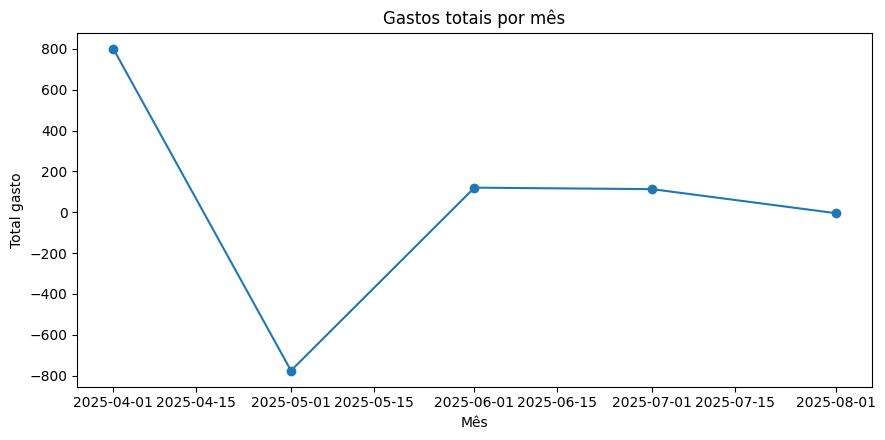

('/content/drive/MyDrive/cloudwalk/data_scientist_test_repo/analysis/stats_by_category.csv',
 '/content/drive/MyDrive/cloudwalk/data_scientist_test_repo/analysis/monthly_totals.csv',
 '/content/drive/MyDrive/cloudwalk/data_scientist_test_repo/assets/seasonality.png')

In [31]:

# Estatísticas por categoria
stats_by_cat = (
    df.groupby("category")["amount"]
      .agg(mean="mean", median="median", std="std", count="count", sum="sum")
      .sort_values("sum", ascending=False)
      .reset_index()
)
display(stats_by_cat.head(20))

# Totais mensais
df["year_month"] = df["date"].dt.to_period("M").astype(str)
monthly_totals = (df.groupby("year_month")["amount"]
                    .sum()
                    .reset_index()
                    .rename(columns={"amount": "total_spend"}))
display(monthly_totals.head())

# Gráfico de sazonalidade
plt.figure(figsize=(9,4.5))
plt.plot(pd.to_datetime(monthly_totals["year_month"]), monthly_totals["total_spend"], marker="o")
plt.title("Gastos totais por mês")
plt.xlabel("Mês"); plt.ylabel("Total gasto"); plt.tight_layout()
seasonality_png = os.path.join(ASSETS_DIR, "seasonality.png")
plt.savefig(seasonality_png, dpi=160)
plt.show()
plt.close()

# Salvar artefatos
stats_by_cat_path = os.path.join(ANALYSIS_DIR, "stats_by_category.csv")
monthly_totals_path = os.path.join(ANALYSIS_DIR, "monthly_totals.csv")
stats_by_cat.to_csv(stats_by_cat_path, index=False)
monthly_totals.to_csv(monthly_totals_path, index=False)

stats_by_cat_path, monthly_totals_path, seasonality_png


## 3) Seção 2 — Padrões e Outliers

In [59]:
# Calcular o coeficiente de variação (CV) por categoria
stats_by_cat["cv"] = stats_by_cat["std"] / (stats_by_cat["mean"].replace(0, np.nan))
var_df = stats_by_cat.dropna(subset=["cv"]).sort_values("cv", ascending=False)
top_var = var_df.head(5)

print("📊 Categorias com maior variabilidade de gasto:")
display(top_var[["category", "mean", "std", "cv", "count", "sum"]])

# Função para detectar outliers usando o método IQR
def iqr_bounds(x):
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

# Detectar e registrar outliers por categoria
outliers = []
for cat, sub in df.groupby("category"):
    if len(sub) < 8:
        continue
    low, up = iqr_bounds(sub["amount"])
    mask = (sub["amount"] < low) | (sub["amount"] > up)
    if mask.any():
        flagged = sub.loc[mask, ["date", "category", "merchant", "amount"]].copy()
        flagged["lower_bound"] = low
        flagged["upper_bound"] = up
        outliers.append(flagged)

outliers_df = (
    pd.concat(outliers, ignore_index=True)
    if outliers
    else pd.DataFrame(columns=["date", "category", "merchant", "amount", "lower_bound", "upper_bound"])
)

# Ordenar e limitar aos 10 outliers mais extremos
if not outliers_df.empty:
    outliers_df["distance"] = outliers_df.apply(
        lambda r: min(abs(r["amount"] - r["lower_bound"]), abs(r["upper_bound"] - r["amount"])),
        axis=1
    )
    outliers_df = outliers_df.sort_values("distance", ascending=False).head(10)

# Exibir resultados
if outliers_df.empty:
    print("⚠️ Nenhum outlier relevante identificado pelo critério IQR.")
else:
    print(f"⚠️ Foram detectados outliers em {outliers_df['category'].nunique()} categorias.")
    print("Principais categorias com outliers:")
    print(outliers_df['category'].unique()[:10])
    display(outliers_df)

# Salvar resultados
outliers_path = os.path.join(ANALYSIS_DIR, "top_outliers.csv")
top_var_path = os.path.join(ANALYSIS_DIR, "stats_variability.csv")
var_df.to_csv(top_var_path, index=False)

print(f"\nArquivos salvos:\n- {top_var_path}\n- {outliers_path}")

📊 Categories with highest spending variability:


,category,mean,std,cv,count,sum
0,Transferência - PIX,482.748789,2071.349787,4.290741,190,91722.27
1,Transferência - Câmbio,2098.890000,2471.380512,1.177470,20,41977.80
2,Transferência - TED,96.620000,70.399551,0.728623,2,193.24
3,Juros de rendimentos de dividendos,0.010000,0.000000,0.000000,4,0.04
30,Celular,-116.054286,12.552892,-0.108164,7,-812.38


⚠️ Outliers detected in 4 categories.
Main categories with outliers:
['Transferência - PIX' 'Transferência mesma titularidade' 'Serviços'
 'Compras']


,date,category,merchant,amount,lower_bound,upper_bound,distance
44,2025-05-30 12:17:23.421,Transferência - PIX,NaN,22122.59,-1275.0000,1725.0000,20397.5900
65,2025-05-30 12:18:01.244,Transferência mesma titularidade,NaN,-21300.00,-1091.0125,750.6075,20208.9875
41,2025-05-02 12:31:39.220,Transferência - PIX,NaN,13093.91,-1275.0000,1725.0000,11368.9100
68,2025-05-02 12:33:00.364,Transferência mesma titularidade,NaN,-10397.00,-1091.0125,750.6075,9305.9875
52,2025-05-17 22:57:52.573,Transferência - PIX,NaN,5779.35,-1275.0000,1725.0000,4054.3500
24,2025-05-17 23:15:16.274,Serviços,"{""cnae"":""6619399"",""cnpj"":""47974698000100"",""nam...",-4103.73,-473.0300,234.0900,3630.7000
53,2025-08-03 01:44:40.524,Transferência mesma titularidade,NaN,-4400.00,-1091.0125,750.6075,3308.9875
36,2025-04-30 16:11:34.838,Transferência - PIX,NaN,5000.00,-1275.0000,1725.0000,3275.0000
48,2025-05-14 12:34:26.628,Transferência - PIX,NaN,4500.00,-1275.0000,1725.0000,2775.0000
1,2025-07-08 18:35:21.639,Compras,NaN,-2246.00,-201.9625,84.3775,2044.0375



Files saved:
- /content/drive/MyDrive/cloudwalk/data_scientist_test_repo/analysis/stats_variability.csv
- /content/drive/MyDrive/cloudwalk/data_scientist_test_repo/analysis/top_outliers.csv


## 4) Relatório

A análise das transações revelou variações expressivas em determinadas categorias de gasto.  
As categorias com maior variabilidade (coeficiente de variação — CV) foram:

- **Transferência – PIX** (CV = 4.29, média =  482,75, desvio =  2.071,35)  
- **Transferência – Câmbio** (CV = 1.18, média =  2.098,89, desvio =  2.471,38)  
- **Transferência – TED** (CV = 0.73, média =  96,62, desvio =  70,40)

Esses resultados indicam comportamento financeiro mais volátil, com transações pontuais de valores elevados que afetam a estabilidade mensal.

Além disso, foram identificados **outliers** nas seguintes categorias:

- **Transferência - PIX**
- **Transferência entre contas de mesma titularidade**
- **Serviços**
- **Compras**

Essas categorias apresentam **movimentações isoladas com valores significativamente acima da média**.  
Os casos podem estar relacionados a **operações não recorrentes**, como **transferências de grande valor** ou **pagamentos extraordinários**, que **distorcem o padrão estatístico de consumo** e **devem ser monitorados** em análises de comportamento financeiro.


Para melhorar o acompanhamento das finanças, propõem-se duas métricas:  
(1) **Overspend Index (OI)** — compara o gasto atual com a média dos três meses anteriores, permitindo identificar picos de gasto;  
(2) **Large Transaction Z-Score (LTZ)** — quantifica o desvio de uma transação em relação à média histórica da categoria.

Essas métricas permitem a criação de alertas automáticos e relatórios inteligentes de comportamento de consumo, favorecendo a gestão financeira e o planejamento pessoal.

---

## 🧮 Definição Formal das Métricas

### 1. Overspend Index (OI)

**Fórmula:**
\[
OI_t = \frac{Gasto_t}{\epsilon + \text{Média}(Gasto_{t-1}, Gasto_{t-2}, Gasto_{t-3})}
\]

**Interpretação:**
- \( OI > 1.25 \) → gasto 25 % acima da média recente  
- \( OI < 0.75 \) → queda acentuada no consumo  

---

### 2. Large Transaction Z-Score (LTZ)

**Fórmula:**
\[
LTZ = \frac{Valor - \mu_{\text{categoria}}}{\sigma_{\text{categoria}} + \epsilon}
\]

**Interpretação:**
- \( |LTZ| \ge 3 \) → transação atípica  
- Permite detectar gastos muito acima (ou abaixo) do padrão da categoria


## 5) Seção 3 — Proposta de Ferramenta Acionável (Fluxo de Alertas)

### Fluxo de Interação

1. **Coleta diária de transações**  
   - O sistema importa automaticamente as novas movimentações do usuário (ex: app bancário ou plataforma de controle financeiro).  

2. **Cálculo automático das métricas**  
   - Para cada categoria e transação:
     - Calcula o **Overspend Index (OI)** → compara o gasto atual com a média dos 3 meses anteriores.  
     - Calcula o **Large Transaction Z-Score (LTZ)** → identifica transações muito acima do padrão da categoria.  

3. **Detecção de eventos anômalos**  
   - Se **OI > 1.25**, o sistema detecta pico de gasto.  
   - Se **|LTZ| ≥ 3**, o sistema detecta transação atípica.  

4. **Geração de alerta**  
   - O sistema envia **notificação push ou e-mail** imediatamente após a detecção (ou em resumo diário).  

5. **Visualização no painel**  
   - O usuário acessa um painel que exibe:
     - Categoria afetada  
     - Valor gasto e média anterior  
     - Tipo de alerta (pico de gasto / transação fora do padrão)  
     - Sugestão de ação (ex: revisar assinatura, confirmar despesa, ajustar orçamento)

6. **Ação do usuário**  
   - O usuário pode **confirmar** a despesa como legítima, **categorizar** novamente, ou **definir novo limite**.

---

### ⚙️ Parâmetros Configuráveis

- **Limite de OI**: valor de alerta (ex: 1.25 padrão, ajustável pelo usuário).  
- **Limite de LTZ**: nível de sensibilidade (ex: 2.5, 3.0).  
- **Frequência de alertas**: imediata, diária ou semanal.  
- **Categorias monitoradas**: o usuário pode ativar/desativar alertas por tipo de gasto.  
- **Canal de notificação**: e-mail, push, SMS.

---

### 💬 Exemplo de Alerta ao Usuário

> **📈 Alerta de Gasto Atípico — Transferência PIX**  
> Seu gasto com **Transferência - PIX** neste mês está **4,2× acima da média recente**.  
>
> 💰 **Valor:** R$ 2.480,00  
> 📅 **Média dos 3 últimos meses:** R$ 590,00  
> ⚠️ Esse aumento pode indicar uma transação pontual ou um novo padrão de consumo.  
>
> ➜ **Sugestão:** revise a transação e, se for um gasto recorrente, atualize seu limite de categoria.

## 6) Seção 4 — Métrica calculável por sistema (código + JSON)

In [57]:
import pandas as pd
import json

def detect_unstable_categories(csv_path, inactive_threshold=10.0):
    """
    Detecta categorias com comportamento não estável do Índice de Gasto Excessivo (Overspend Index - OI) a partir de um arquivo CSV de transações.

    Uma categoria é classificada como:
        - "upward"   → OI > 1.05 (aumento de gastos)
        - "downward" → OI < 0.95 (redução de gastos)
        - "inactive" → gasto total do último mês < inactive_threshold
        - "stable"   → caso contrário (não retornada aqui)

    Parâmetros:
        csv_path (str): Caminho do arquivo CSV de transações.
        inactive_threshold (float): Gasto mínimo mensal para considerar uma categoria ativa.

    Retorna:
        String JSON contendo apenas as categorias não estáveis.
    """

    epsilon = 1e-9

    # Carregar e pré-processar os dados
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')

    # Manter apenas transações de débito (saídas)
    df = df[df['amount'] < 0].copy()
    df['amount'] = df['amount'].abs()

    # Extrair o ano e mês
    df['year_month'] = df['date'].dt.to_period('M')

    # Calcular o gasto mensal por categoria
    monthly = (
        df.groupby(['category', 'year_month'])['amount']
        .sum()
        .reset_index()
        .sort_values(['category', 'year_month'])
    )

    # Calcular a média móvel dos últimos 3 meses
    monthly['rolling_mean'] = (
        monthly.groupby('category')['amount']
        .apply(lambda x: x.shift(1).rolling(3, min_periods=3).mean())
        .reset_index(level=0, drop=True)
    )

    # Calcular o Índice de Gasto Excessivo (Overspend Index - OI)
    monthly['OI'] = monthly['amount'] / (monthly['rolling_mean'] + epsilon)

    # Selecionar o registro mais recente de cada categoria
    latest = monthly.groupby('category').tail(1).copy()

    # Classificar a tendência de forma segura
    def classify_trend(row):
        if row['amount'] < inactive_threshold:
            return "inactive"
        elif row['OI'] > 1.05:
            return "upward"
        elif row['OI'] < 0.95:
            return "downward"
        else:
            return "stable"

    latest.loc[:, 'trend'] = latest.apply(classify_trend, axis=1)

    # Manter apenas categorias não estáveis
    unstable = latest[latest['trend'] != 'stable']

    # Construir a lista de resultados
    results = []
    for _, row in unstable.iterrows():
        results.append({
            "metric_name": "Overspend Index",
            "category": row['category'],
            "year_month": str(row['year_month']),
            "value": round(float(row['OI']), 2),
            "trend": row['trend']
        })

    return json.dumps(results, indent=4, ensure_ascii=False)

In [58]:
print(detect_unstable_categories(f'{CSV_PATH}'))

[
    {
        "metric_name": "Overspend Index",
        "category": "Atraso no pagamento e custos de cheque especial",
        "year_month": "2025-06",
        "value": NaN,
        "trend": "inactive"
    },
    {
        "metric_name": "Overspend Index",
        "category": "Delivery de alimentos",
        "year_month": "2025-07",
        "value": 0.75,
        "trend": "downward"
    },
    {
        "metric_name": "Overspend Index",
        "category": "Farmácia",
        "year_month": "2025-07",
        "value": 0.21,
        "trend": "downward"
    },
    {
        "metric_name": "Overspend Index",
        "category": "Impostos sobre operações financeiras",
        "year_month": "2025-07",
        "value": NaN,
        "trend": "inactive"
    },
    {
        "metric_name": "Overspend Index",
        "category": "Pedágios e pagamentos no veículo",
        "year_month": "2025-07",
        "value": 0.26,
        "trend": "downward"
    },
    {
        "metric_name": "Overspend I